In [1]:
import os

OPENSLIDE_PATH = r"D:\DataManage\openslide-win64-20231011\bin"
if hasattr(os, "add_dll_directory"):
    # Windows
    with os.add_dll_directory(OPENSLIDE_PATH):
        import openslide
else:
    import openslide

import numpy as np
import openslide
import xml.etree.ElementTree as ET
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from typing import List, Tuple

from extract_annotations import process_sample, extract_polygons
from polygons import Polygon_Opti
from tqdm import tqdm

# MDN

In [2]:
summ_df = pd.read_csv(r"C:\Users\inserm\Documents\histo_sign\dataset\mdn_summary_uq.csv")
summ_df.path_svs = summ_df.path_svs.apply(Path)
summ_df.path_xml = summ_df.path_xml.apply(Path)
summ_df["Layer_id"] = summ_df.sample_ID.apply(lambda x: x.split("_L")[1].split("_")[0]).astype(int)
summ_df.sort_values("ID_scan", inplace=True)
summ_df.reset_index(drop=True, inplace=True)

In [3]:
path_coord = Path(r"C:\Users\inserm\Documents\histo_sign\dataset\non_white_coordinates_mdn")
tile_size = 224

In [4]:
# row = summ_df.iloc[4]
row = summ_df.iloc[np.random.randint(len(summ_df))]
row.sample_ID

'BPDAC_061_17_L1'

In [5]:
tiles_coord = np.load(path_coord / row.ID_scan / "tiles_coord.npy")
slide = openslide.OpenSlide(str(row.path_svs))

In [6]:
valid_tile = process_sample(row.Layer_id, row.path_xml, tiles_coord, tile_size=tile_size)

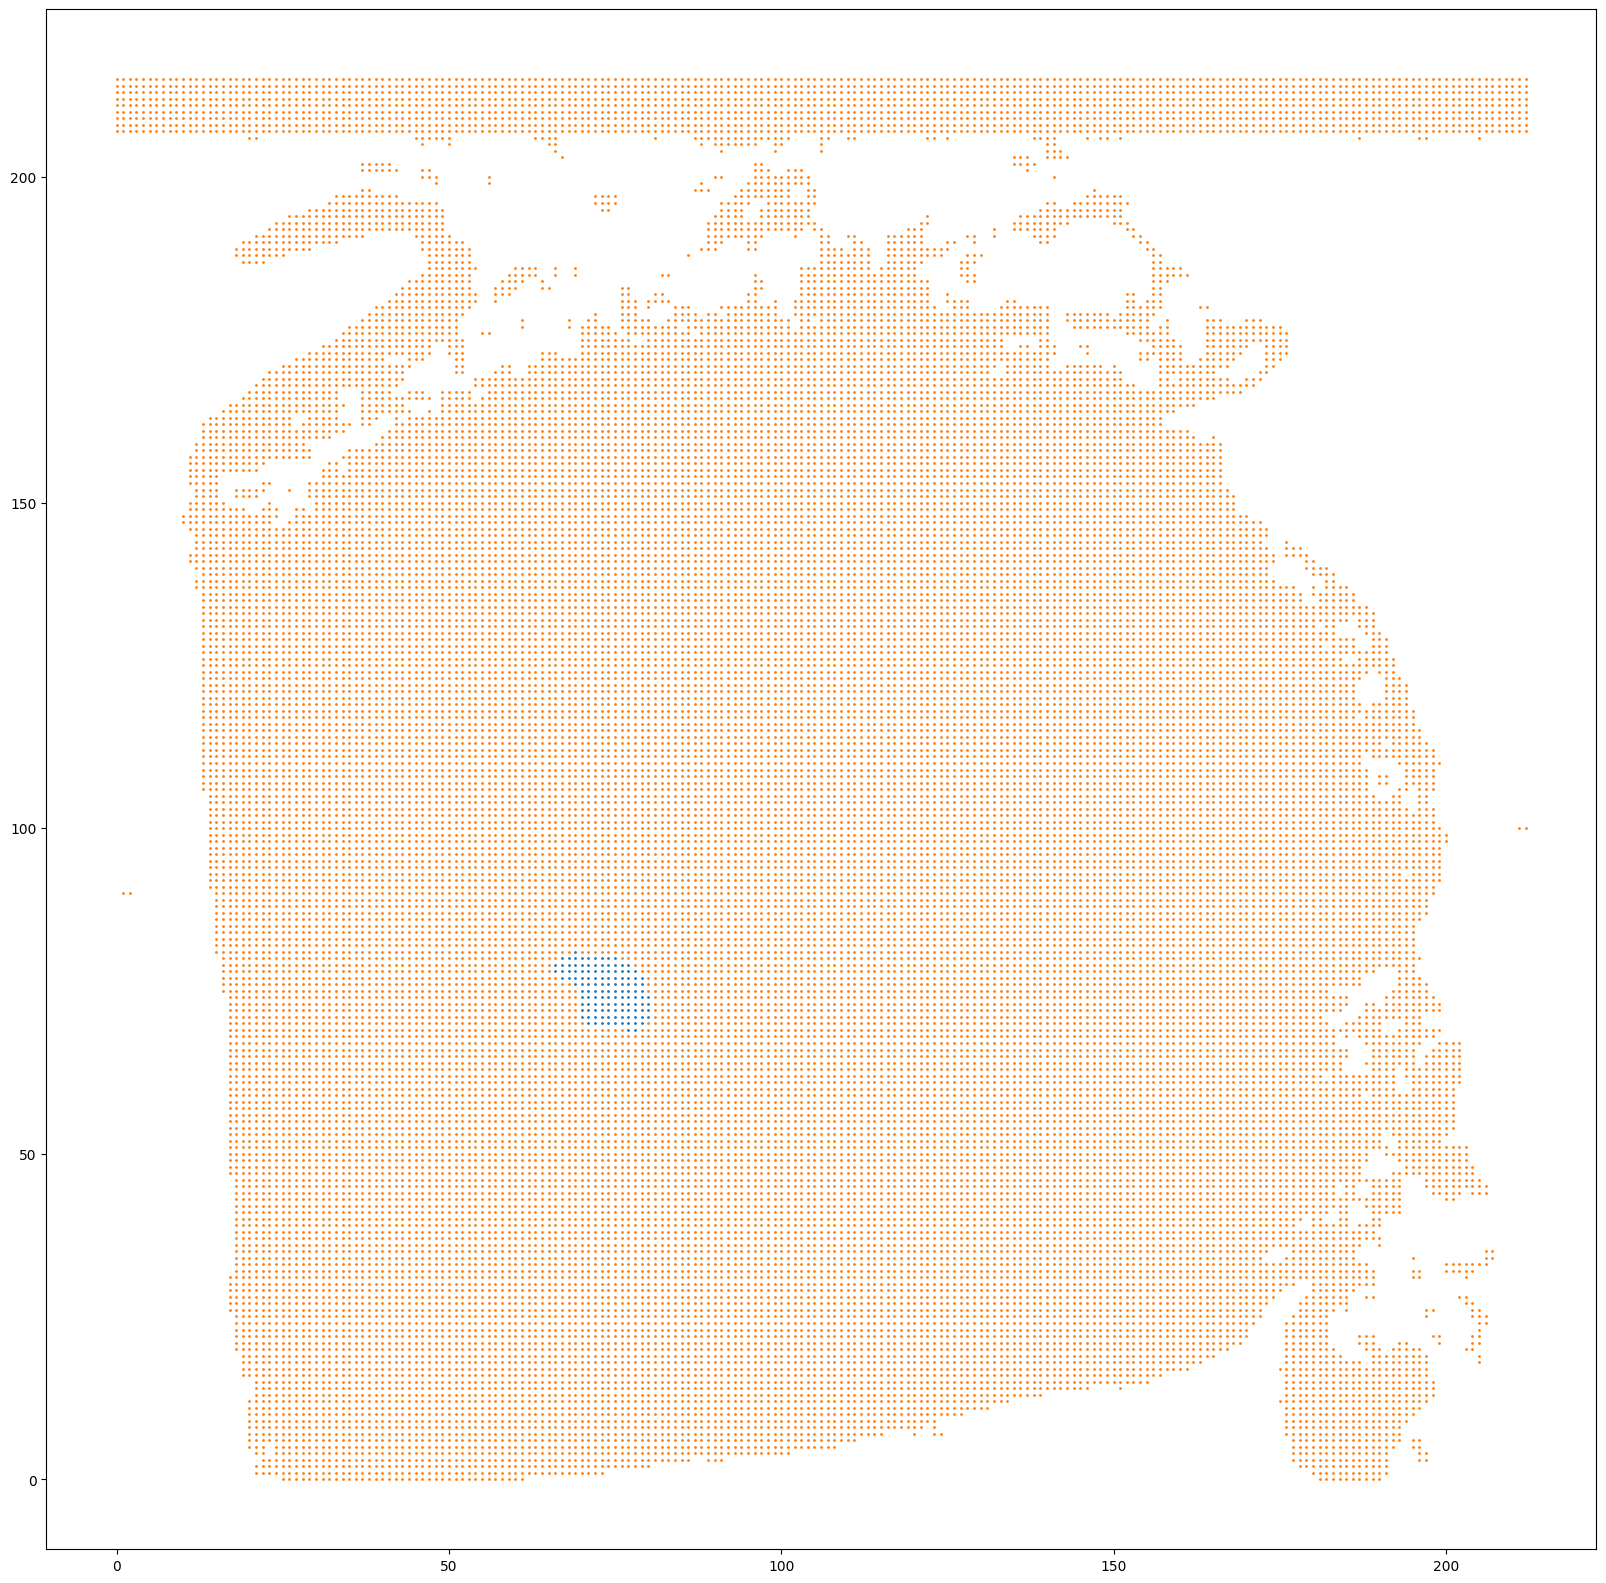

In [7]:
plt.figure(figsize=(20, 20))
plt.scatter(tiles_coord[valid_tile, 2], tiles_coord[valid_tile, 3], s=1)

plt.scatter(tiles_coord[~valid_tile, 2], tiles_coord[~valid_tile, 3], s=1)

# Panc multicentric

In [2]:
from extract_annotations_panc import extract_polygons

In [3]:
path_summary = Path(r"C:\Users\inserm\Documents\histo_sign\dataset\panc_summary_vst.csv")

coord_path = Path(r"C:\Users\inserm\Documents\histo_sign\dataset\non_white_coordinates_panc_224")
annot_path = Path(r"C:\Users\inserm\Documents\histo_sign\dataset\coordinates_panc_224")

In [4]:
panc_df = pd.read_csv(path_summary)
panc_df.path_svs = panc_df.path_svs.apply(Path)
panc_df.path_xml = panc_df.path_xml.apply(Path)
panc_df.tail()

,sample_ID,patient_ID,cohort,path_svs,path_xml,batch,Exocrine,Endocrine,Classic,StromaActiv,...,PDAC_PDXph1_classical,PDAC_PDXph1_basal,PDAC_CSY20_ClassicalA,PDAC_CSY20_BasallikeA,PDAC_CSY20_Sig3,PDAC_CSY20_Sig5,PDAC_CSY20_ClassicalB,PDAC_CSY20_Sig8,PDAC_CSY20_Sig9,PDAC_CSY20_Sig12
727,G9904329-6Q,G9904329,DISC,D:\PACPaint_homemade\datasets\DISC\G9904329-6Q...,D:\PACPaint_homemade\datasets\DISC\G9904329-6Q...,microarray,0.284243,1.918326,0.460105,-0.039140,...,0.498494,0.228968,0.586811,0.294604,0.517717,1.122747,0.099690,1.946139,1.019977,-0.193110
728,G9905909-8H,G9905909,DISC,D:\PACPaint_homemade\datasets\DISC\G9905909-8H...,D:\PACPaint_homemade\datasets\DISC\G9905909-8H...,microarray,1.627957,0.587344,0.168653,0.518969,...,-0.040594,0.212950,0.091471,-0.054144,0.700051,0.876776,0.316757,0.058906,-0.190822,0.268387
729,G9905909-8J,G9905909,DISC,D:\PACPaint_homemade\datasets\DISC\G9905909-8J...,D:\PACPaint_homemade\datasets\DISC\G9905909-8J...,microarray,1.627957,0.587344,0.168653,0.518969,...,-0.040594,0.212950,0.091471,-0.054144,0.700051,0.876776,0.316757,0.058906,-0.190822,0.268387
730,G9906696-5O,G9906696,DISC,D:\PACPaint_homemade\datasets\DISC\G9906696-5O...,D:\PACPaint_homemade\datasets\DISC\G9906696-5O...,microarray,-0.036153,-1.611128,-0.173178,0.319878,...,-0.909680,-0.384114,-0.470962,-1.116800,-0.426746,-1.180976,-1.287977,-1.413884,-1.476346,-0.722155
731,G9906696-5R,G9906696,DISC,D:\PACPaint_homemade\datasets\DISC\G9906696-5R...,D:\PACPaint_homemade\datasets\DISC\G9906696-5R...,microarray,-0.036153,-1.611128,-0.173178,0.319878,...,-0.909680,-0.384114,-0.470962,-1.116800,-0.426746,-1.180976,-1.287977,-1.413884,-1.476346,-0.722155


In [5]:
row = panc_df.iloc[np.random.randint(len(panc_df))]
tiles_coord = np.load(annot_path / row.sample_ID / "tiles_coord.npy")

In [6]:
slide = openslide.OpenSlide(str(row.path_svs))
zoom_level = int(slide.properties["openslide.objective-power"])
downsampling_factor = 1 if zoom_level == 20 else 2
tile_size = 224

final_pol_list, final_neg_roa_list, resolution = extract_polygons(row.path_xml)
tiles_coord_micro = tiles_coord.copy().astype(float)
tiles_coord_micro[:, 2] *= tile_size * resolution * downsampling_factor
tiles_coord_micro[:, 3] *= tile_size * resolution * downsampling_factor

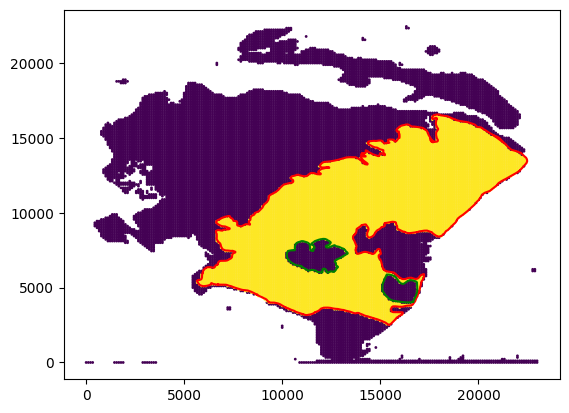

In [7]:
pts = tiles_coord_micro[:, 2:5]
plt.scatter(pts[:, 0], pts[:, 1], s=1, c=pts[:, 2])
for pol, roa in zip(final_pol_list, final_neg_roa_list):
    if roa:
        plt.plot(pol[:, 0], pol[:, 1], c="g")
    else:
        plt.plot(pol[:, 0], pol[:, 1], c="r")

In [10]:
from openslide.deepzoom import DeepZoomGenerator

dz = DeepZoomGenerator(slide, tile_size=224, overlap=0)

In [51]:
n_pos = 9
# sample n_pos positive tiles
pos_idx = tiles_coord[tiles_coord[:, 4] == 1]
pos_idx = pos_idx[np.random.choice(len(pos_idx), n_pos, replace=False)]
pos_idx = pos_idx.astype(int)
pos_list_img = [dz.get_tile(pts[0], pts[2:4]) for pts in pos_idx]
# sample n_pos negative tiles
neg_idx = tiles_coord[tiles_coord[:, 4] == 0]
neg_idx = neg_idx[np.random.choice(len(neg_idx), n_pos, replace=False)]
neg_idx = neg_idx.astype(int)
neg_list_img = [dz.get_tile(pts[0], pts[2:4]) for pts in neg_idx]

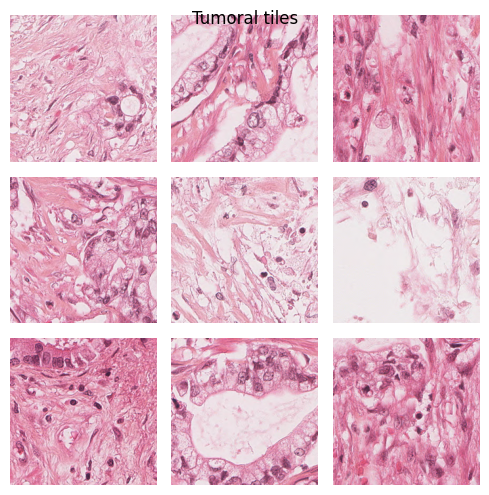

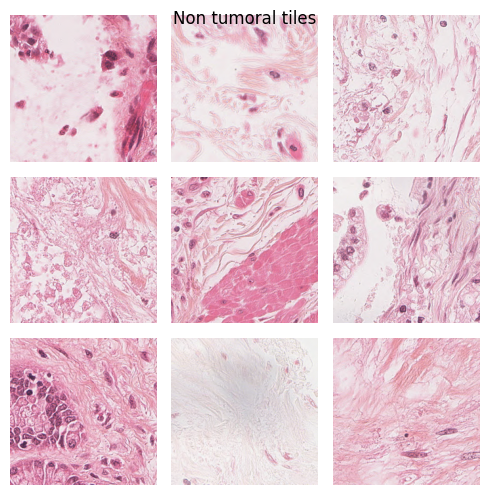

In [67]:
# plot the positive and negative tiles
fig, axes = plt.subplots(3, 3, figsize=(5, 5))
axes = axes.ravel()
for ax, img in zip(axes, pos_list_img):
    ax.imshow(img)
    ax.axis("off")
plt.tight_layout()
plt.suptitle("Tumoral tiles")
plt.show()

fig, axes = plt.subplots(3, 3, figsize=(5, 5))
axes = axes.ravel()
for ax, img in zip(axes, neg_list_img):
    ax.imshow(img)
    ax.axis("off")
plt.tight_layout()
plt.suptitle("Non tumoral tiles")
plt.show()